This notebook examines the impact of the mistake in the tidal ramping in the CIOPS-E .

Strategy:
1. Remove tides
2. Compute residual current
3. Compute power spectrum

In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytides.tide import Tide
from scipy import signal
import xarray as xr

%matplotlib inline

In [2]:
data_dir='/home/soontiensn/data/gpsc-work2/CIOPSE_SN1500/catchup/tests/'

# Tidal analysis on U

In [3]:
files_U=glob.glob(os.path.join(data_dir, '*_000', '*grid_U*'))
files_U = [i for i in files_U if not ('201912' in i)]
files_U.sort()
du_2D = xr.open_mfdataset(files_U)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [4]:
restart_days = []
for f in files_U:
    d=os.path.basename(os.path.dirname(f))
    date=datetime.datetime.strptime(d.split('_')[0],'%Y%m%d%H')
    restart_days.append(date)
print(restart_days)

[datetime.datetime(2019, 5, 12, 0, 0), datetime.datetime(2019, 5, 19, 0, 0), datetime.datetime(2019, 5, 26, 0, 0), datetime.datetime(2019, 6, 2, 0, 0), datetime.datetime(2019, 6, 9, 0, 0), datetime.datetime(2019, 6, 16, 0, 0), datetime.datetime(2019, 6, 23, 0, 0), datetime.datetime(2019, 6, 30, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 7, 14, 0, 0), datetime.datetime(2019, 7, 21, 0, 0), datetime.datetime(2019, 7, 28, 0, 0), datetime.datetime(2019, 8, 4, 0, 0), datetime.datetime(2019, 8, 11, 0, 0), datetime.datetime(2019, 8, 18, 0, 0), datetime.datetime(2019, 8, 25, 0, 0), datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2019, 9, 8, 0, 0), datetime.datetime(2019, 9, 15, 0, 0), datetime.datetime(2019, 9, 22, 0, 0), datetime.datetime(2019, 9, 29, 0, 0), datetime.datetime(2019, 10, 6, 0, 0), datetime.datetime(2019, 10, 13, 0, 0), datetime.datetime(2019, 10, 20, 0, 0), datetime.datetime(2019, 10, 27, 0, 0), datetime.datetime(2019, 11, 3, 0, 0), datetime.datet

(1400, 850)
(800, 400)
(500, 600)
(100, 10)
(400, 750)


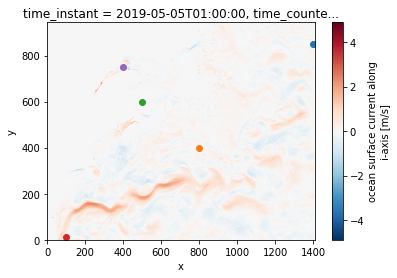

In [5]:
coords= [(1400, 850), (800,400), (500,600), (100,10), (400,750)]
n=len(coords)
colors=['C{}'.format(l) for l in range(n)]
fig,ax=plt.subplots(1,1)
du_2D.uos.isel(time_counter=0).plot(ax=ax)
for c, color in zip(coords, colors):
    print(c)
    ax.plot(c[0], c[1],'o',color=color)

In [6]:
def tidal_analysis(speeds, print_const=True):
    demeaned = speeds.values - speeds.values.mean()
    dates=pd.to_datetime(speeds.time_counter.values)
    tide = Tide.decompose(demeaned,dates )
    
    #print constituents
    constituent = [c.name for c in tide.model['constituent']]
    df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
    if print_const:
        print(df.sort_values('amplitude', ascending=False).head(5))
    
    #tidal prediction
    hours = np.cumsum(np.r_[0, [t.total_seconds() / 3600.0
                            for t in np.diff(dates.to_pydatetime())]])
    times = Tide._times(dates[0], hours)
    prediction = pd.Series(tide.at(times) + speeds.values.mean(), index=dates)
    
    return tide, prediction

    amplitude       phase
M2   0.031118   35.818885
S2   0.010830   84.521869
Mf   0.009999  213.002807
N2   0.007757  351.368032
K2   0.006524  358.833458
     amplitude       phase
M2    0.025286  193.200198
S2    0.020723  285.500234
Mm    0.018836   50.927345
Mf    0.015112   37.369185
2Q1   0.010738   42.604215
    amplitude       phase
M2   0.056133  283.872662
K1   0.015672  314.099640
O1   0.015468  346.993327
N2   0.011724  262.711631
T2   0.010010   17.347071
     amplitude       phase
Mm    0.054375  118.432017
MSF   0.039472   86.884047
OO1   0.009077  347.242713
K1    0.008562  339.114763
O1    0.008270  273.549048
    amplitude       phase
M2   0.183929  283.552093
N2   0.034860  251.609574
K2   0.029246   19.716888
R2   0.027326    0.084063
Mm   0.026375   10.688080


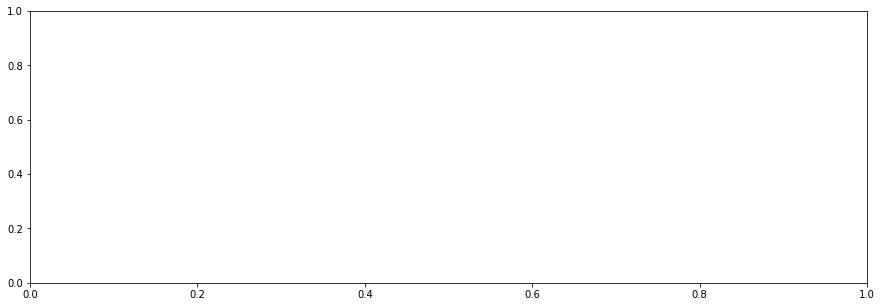

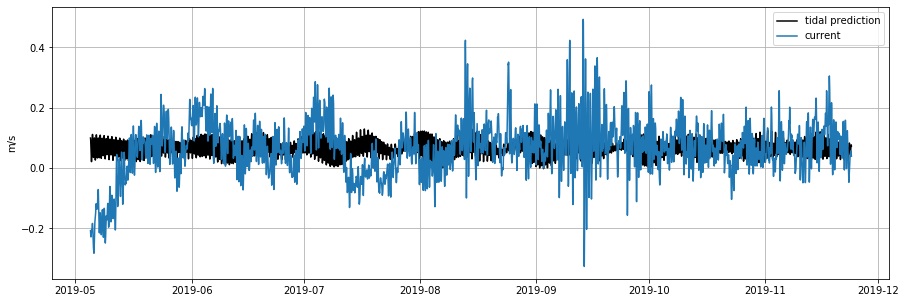

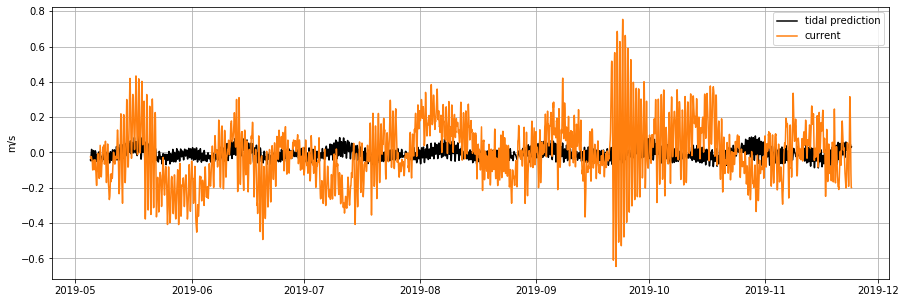

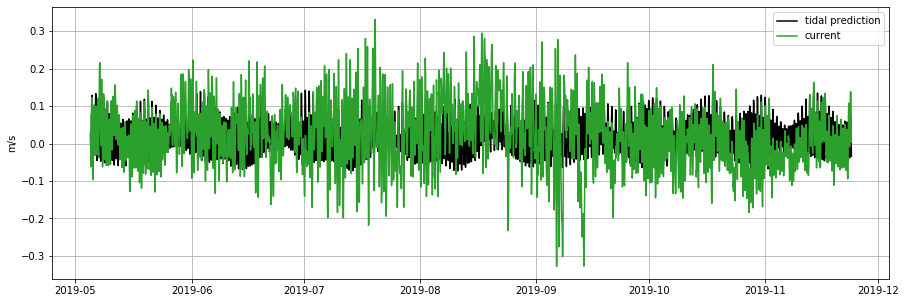

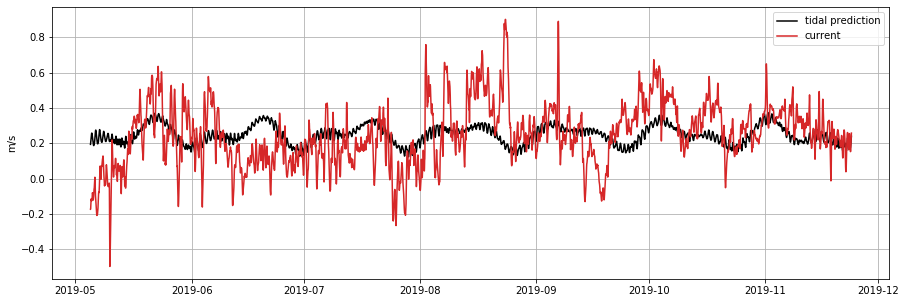

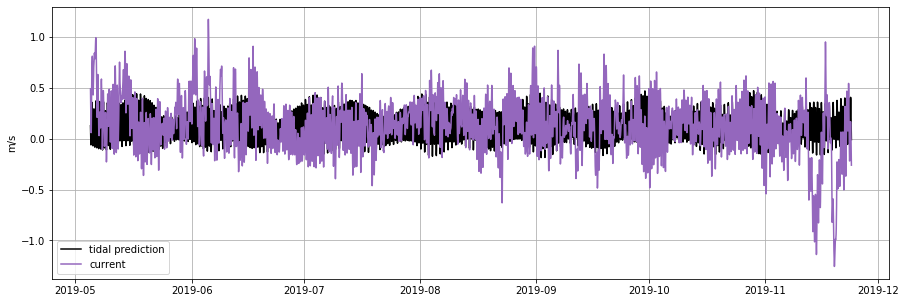

In [7]:
figs, axs=plt.subplots(1,1,figsize=(15,5))
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = du_2D.uos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds)
    ax.plot(speeds.time_counter, prediction.values, color='k', label='tidal prediction')
    ax.plot(speeds.time_counter, speeds.values, color=color, label='current',zorder=10)
    ax.grid()
    ax.legend()
    ax.set_ylabel('m/s')

## Residuals

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

(0, 20000)

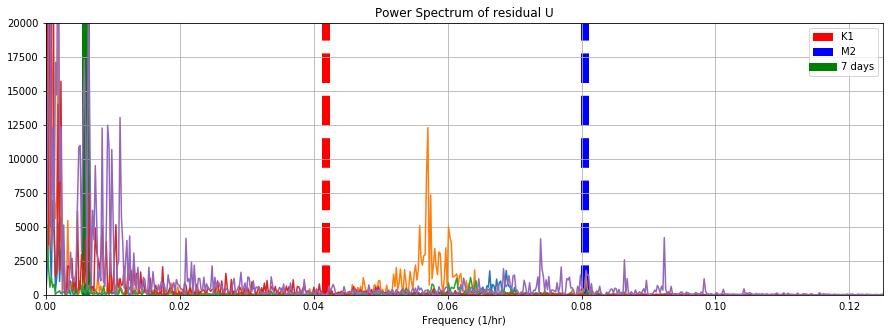

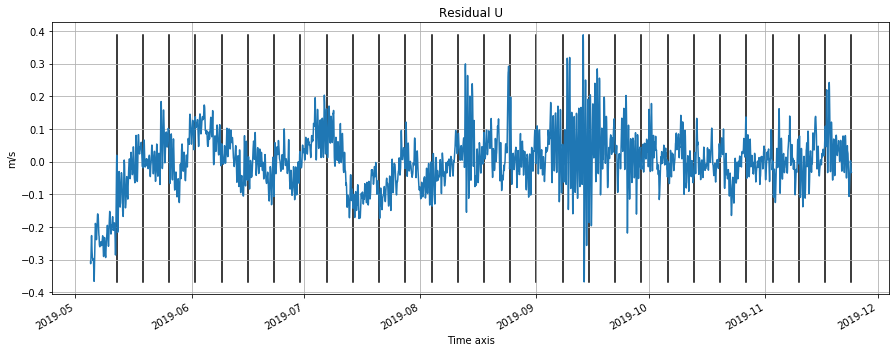

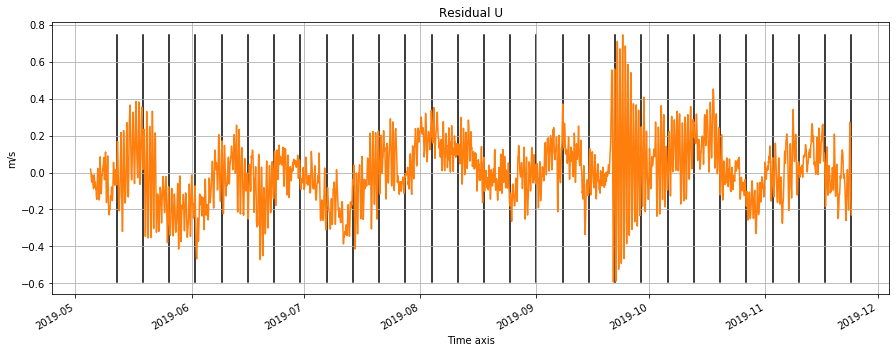

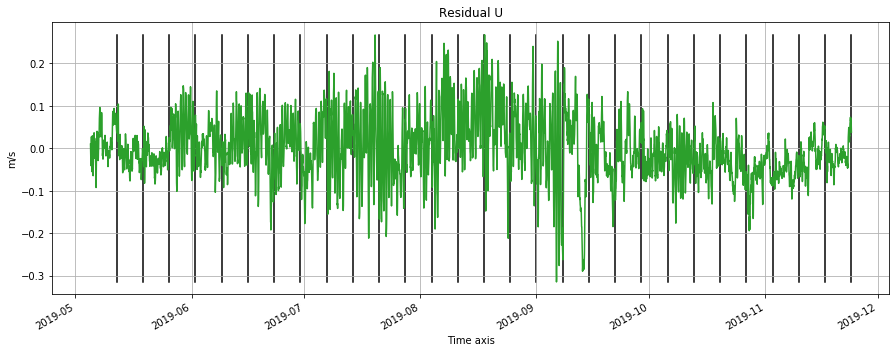

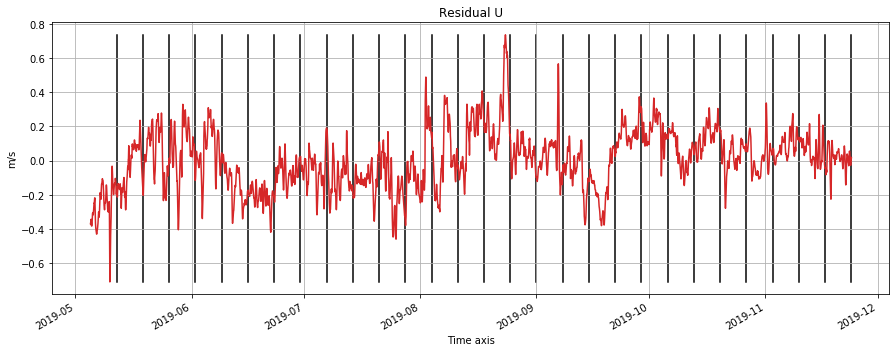

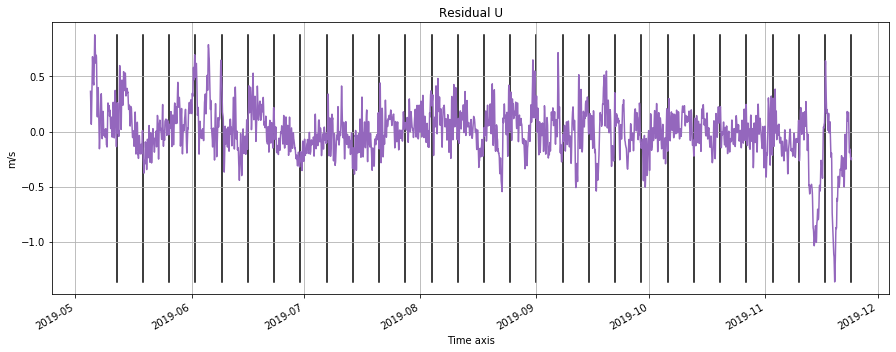

In [8]:
figs, axs=plt.subplots(1,1,figsize=(15,5))
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = du_2D.uos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    residual.plot(ax=ax, color=color)
    ax.set_title('Residual U')
    minvar=residual.min()
    maxvar=residual.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-',zorder=0)
    ax.grid()
    ax.set_ylabel('m/s')
    
    # power spectrum
    freqs = np.fft.fftfreq(residual.values.size, 1)
    idx = np.argsort(freqs)
    psd = np.abs(np.fft.fft(residual.values))**2
    axs.plot(freqs[idx], psd[idx], c=color, label='__nolegend__')
axs.set_title('Power Spectrum of residual U')
axs.grid()
m=20000
# K1
axs.plot([1/23.93, 1/23.93], [0,m], 'r--', lw=8,label='K1',zorder=0)
# M2
axs.plot([1/12.42, 1/12.42], [0,m], 'b--', lw=8, label='M2',zorder=0)
# 7 days
axs.plot([1/(7*24.), 1/(7*24.)], [0,m], 'g-', lw=8, label='7 days',zorder=0)
axs.legend()
axs.set_xlabel('Frequency (1/hr)')
axs.set_xlim([0,0.125])
axs.set_ylim([0,m])

## Daily average residual

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

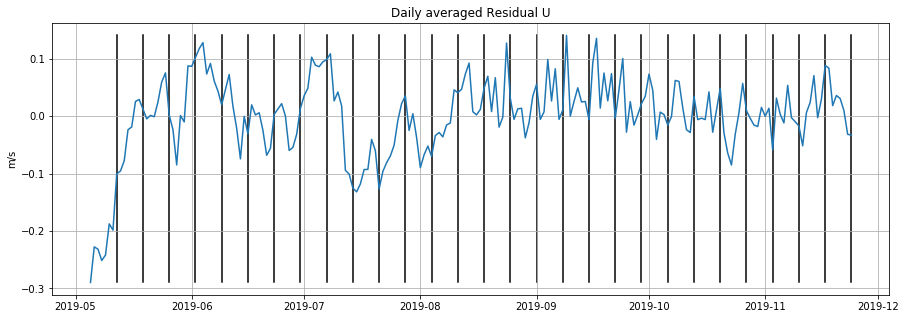

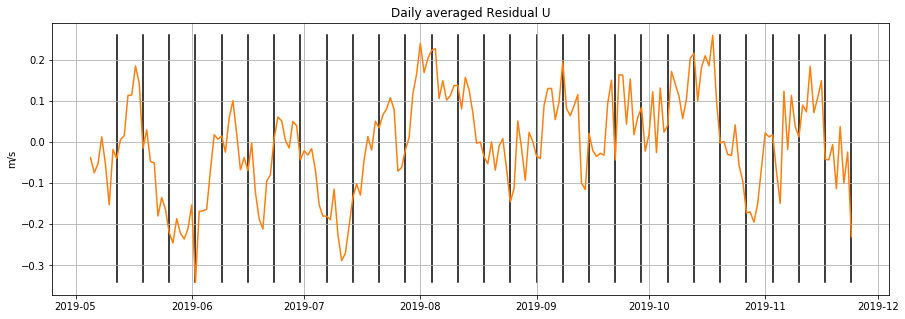

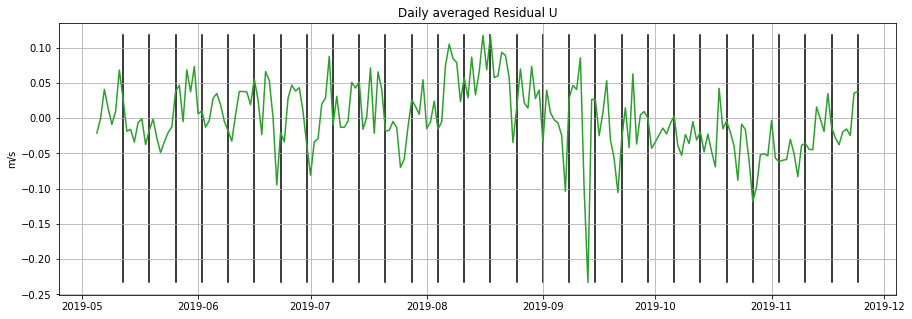

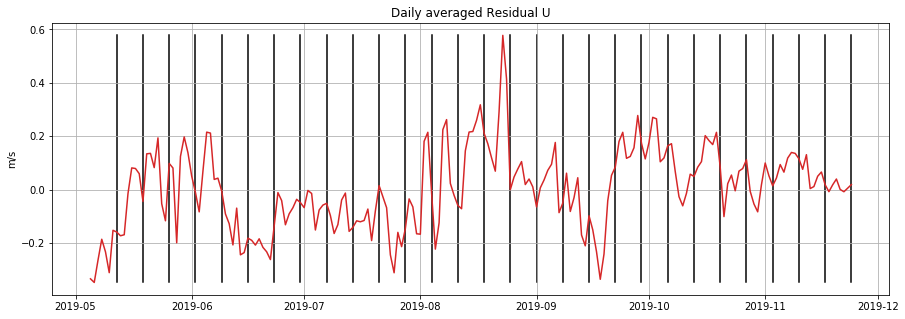

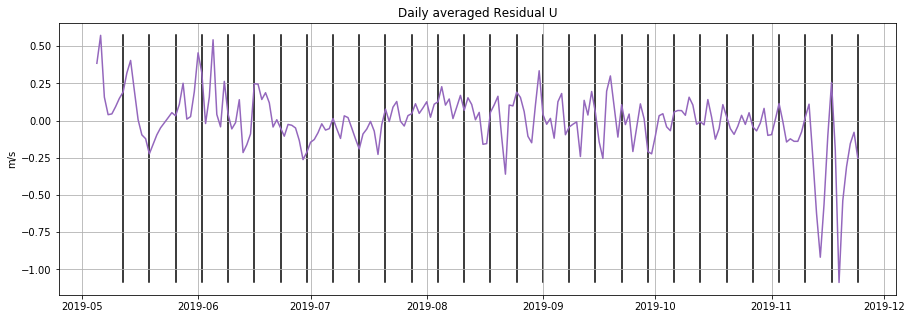

In [9]:
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = du_2D.uos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    daily = residual.to_dataframe(name='uos').resample('1D').mean()
    ax.plot(daily.index, daily.uos.values, color=color)
    ax.set_title('Daily averaged Residual U')
    ax.set_ylabel('m/s')
    minvar=daily.uos.min()
    maxvar=daily.uos.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-',zorder=0)
    ax.grid()

# Tidal analysis for V

In [10]:
files_V=glob.glob(os.path.join(data_dir, '*_000', '*grid_V*'))
files_V = [i for i in files_V if not ('201912' in i)]
files_V.sort()
dv_2D = xr.open_mfdataset(files_V)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


     amplitude       phase
Mm    0.035126   28.899003
MSF   0.019136   29.913431
S1    0.008031  315.074548
R2    0.006889  235.819893
K2    0.006643  254.888229
     amplitude       phase
Mm    0.053059  238.058951
M2    0.045798  121.638990
MSF   0.021068  343.814989
S2    0.019061  205.395663
2Q1   0.010087  295.784614
    amplitude       phase
M2   0.078742   90.578439
K1   0.025732  163.231768
P1   0.020700  128.805634
N2   0.019031   59.363947
S2   0.018340  124.454205
     amplitude       phase
MSF   0.063646   95.258174
Mf    0.059625  184.995288
Mm    0.030271  171.694790
S1    0.015832  260.516250
K1    0.012523  198.415597
     amplitude       phase
M2    0.058344  243.558085
MSF   0.035920  137.860054
Mm    0.033442   33.479816
Mf    0.033341  331.643546
K2    0.018584  311.320147


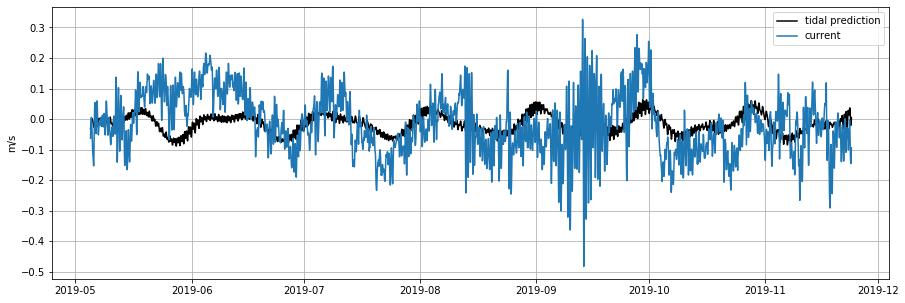

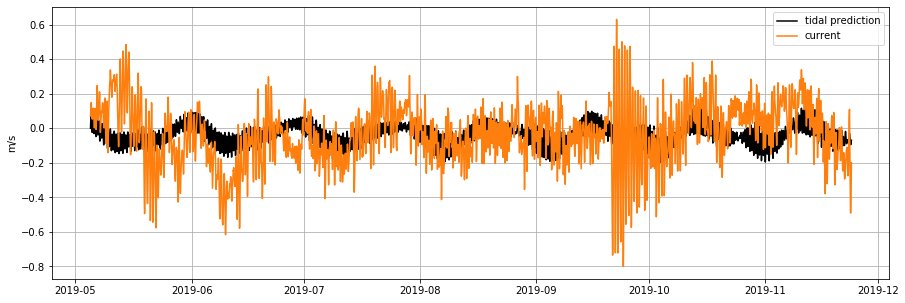

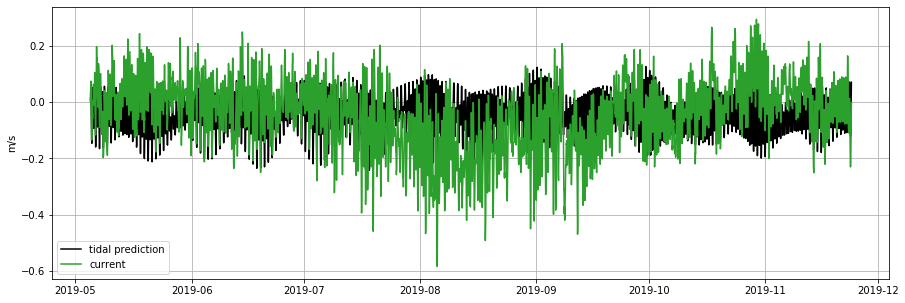

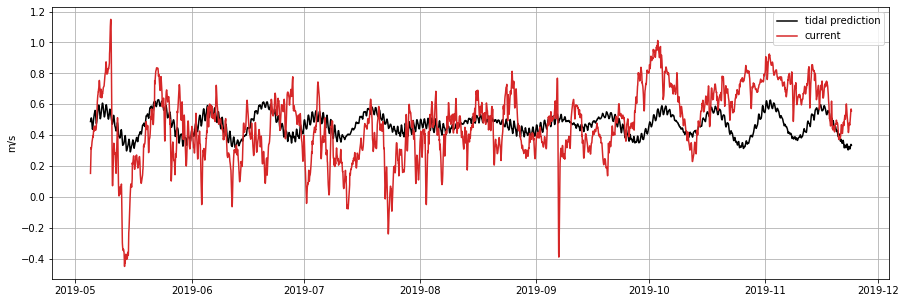

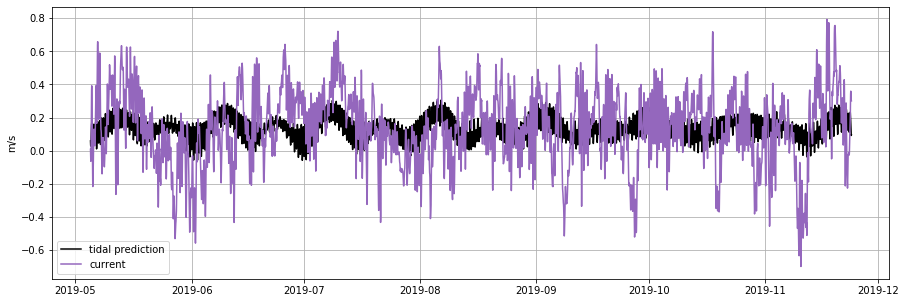

In [11]:
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dv_2D.vos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds)
    ax.plot(speeds.time_counter, prediction.values, color='k', label='tidal prediction')
    ax.plot(speeds.time_counter, speeds.values, color=color, label='current',zorder=10)
    ax.grid()
    ax.legend()
    ax.set_ylabel('m/s')

## Residuals

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

(0, 20000)

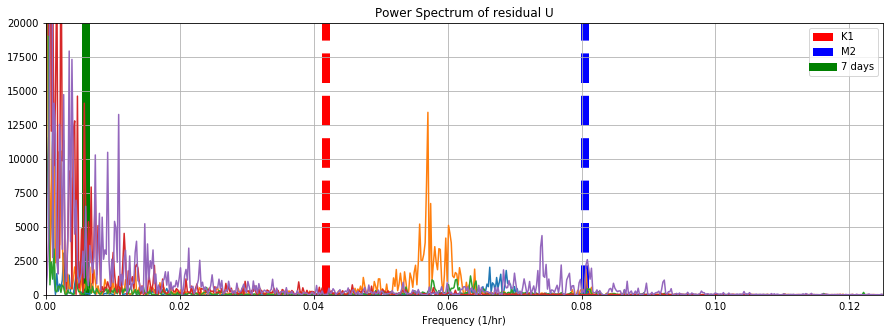

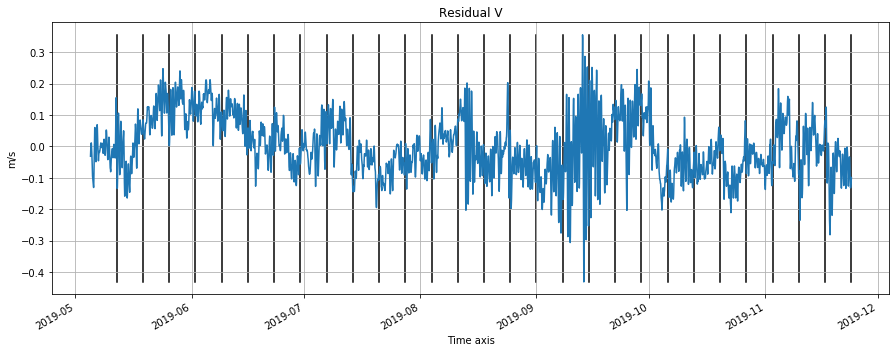

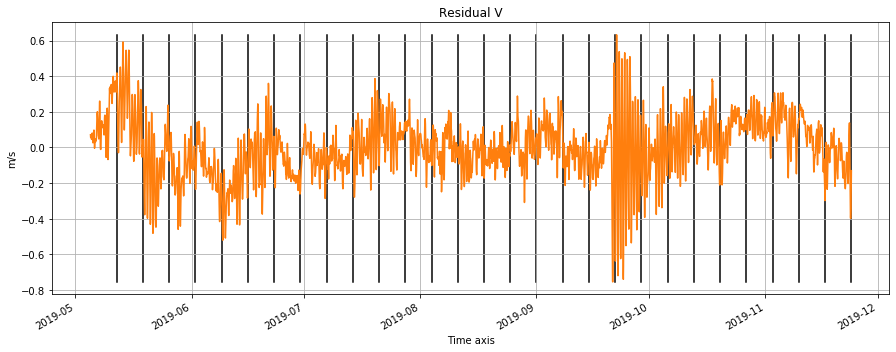

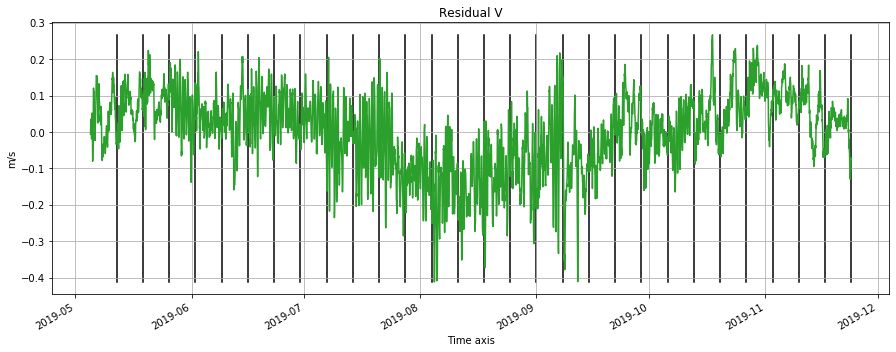

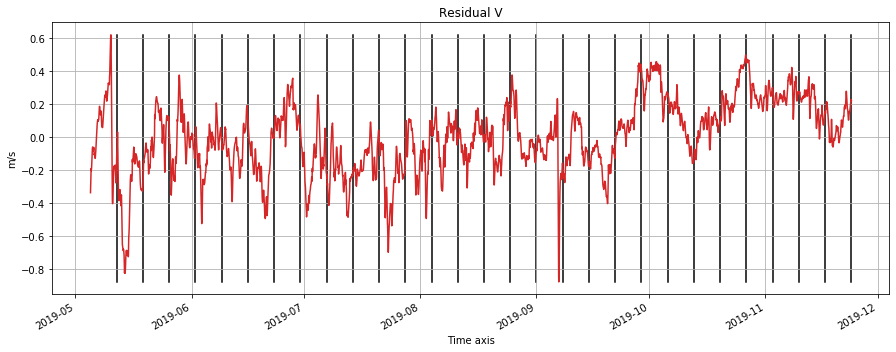

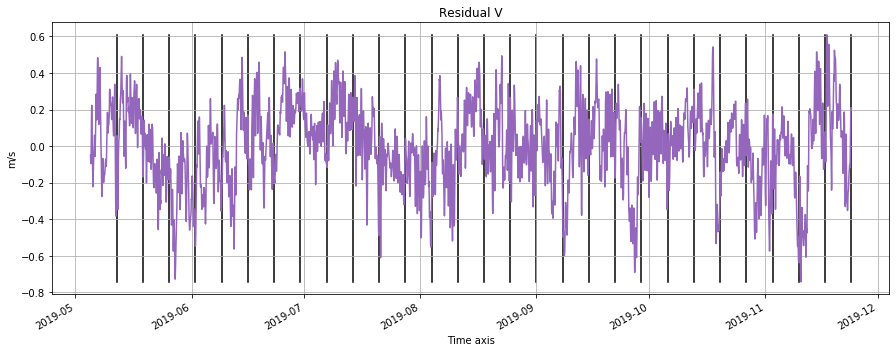

In [12]:
figs, axs=plt.subplots(1,1,figsize=(15,5))
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dv_2D.vos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    residual.plot(ax=ax, color=color)
    ax.set_title('Residual V')
    minvar=residual.min()
    maxvar=residual.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-',zorder=0)
    ax.grid()
    ax.set_ylabel('m/s')
    # power spectrum
    freqs = np.fft.fftfreq(residual.values.size, 1)
    idx = np.argsort(freqs)
    psd = np.abs(np.fft.fft(residual.values))**2
    axs.plot(freqs[idx], psd[idx], c=color, label='__nolegend__')
axs.set_title('Power Spectrum of residual U')
axs.grid()
m=20000
# K1
axs.plot([1/23.93, 1/23.93], [0,m], 'r--', lw=8,label='K1',zorder=0)
# M2
axs.plot([1/12.42, 1/12.42], [0,m], 'b--', lw=8, label='M2',zorder=0)
# 7 days
axs.plot([1/(7*24.), 1/(7*24.)], [0,m], 'g-', lw=8, label='7 days',zorder=0)
axs.legend()
axs.set_xlabel('Frequency (1/hr)')
axs.set_xlim([0,0.125])
axs.set_ylim([0,m])

## Daily average residual

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

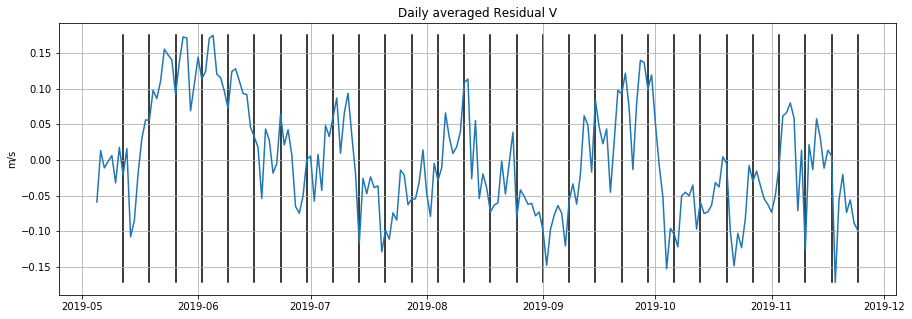

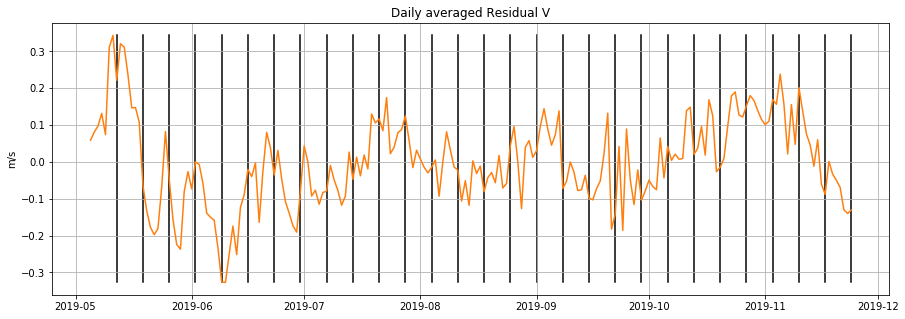

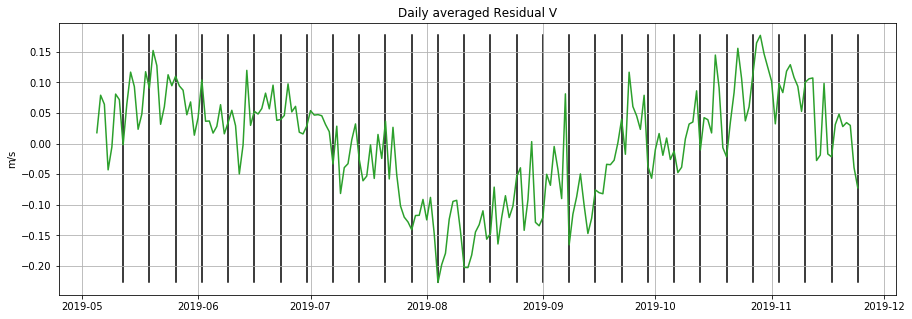

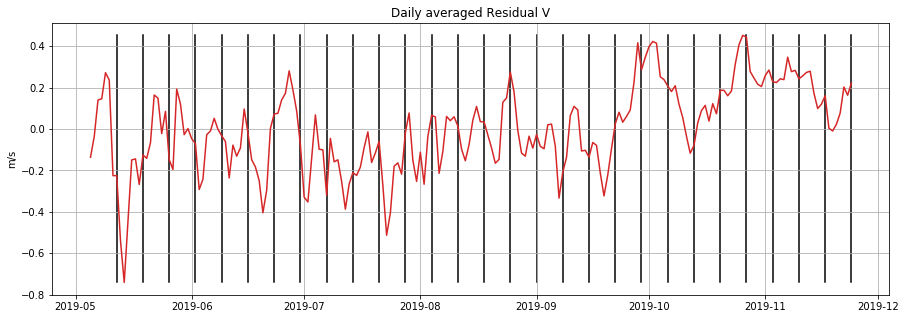

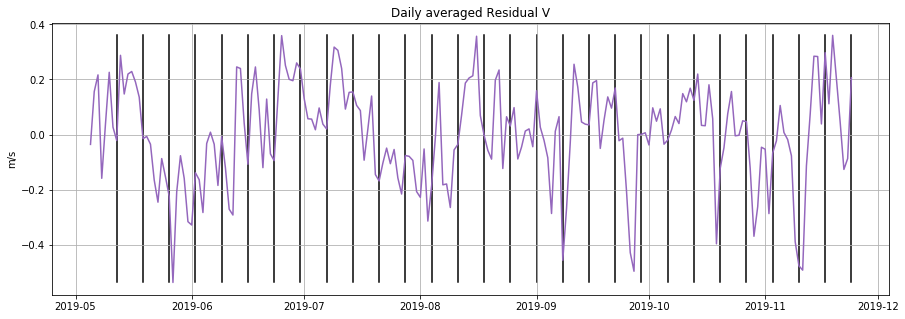

In [13]:
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dv_2D.vos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    daily = residual.to_dataframe(name='vos').resample('1D').mean()
    ax.plot(daily.index, daily.vos.values, color=color)
    ax.set_title('Daily averaged Residual V')
    minvar=daily.vos.min()
    maxvar=daily.vos.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-',zorder=0)
    ax.grid()
    ax.set_ylabel('m/s')

# Tidal analysis for SSH

In [14]:
files_T=glob.glob(os.path.join(data_dir, '*_000', '*grid_T*'))
files_T = [i for i in files_T if not ('201912' in i)]
files_T.sort()
dt_2D = xr.open_mfdataset(files_T)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


    amplitude       phase
M2   0.145166  202.980159
K1   0.070883  142.490280
S2   0.051626  259.961257
O1   0.036127   95.710683
N2   0.026046  175.325300
    amplitude       phase
M2   0.387233  338.859073
N2   0.084515  317.809788
S2   0.084208    7.850200
K1   0.056290  164.891690
O1   0.048328  172.593939
    amplitude       phase
M2   0.217526  267.268184
K1   0.174974  302.100211
O1   0.160223  274.974980
P1   0.068420  292.525722
N2   0.056805  238.708966
    amplitude       phase
M2   0.408752  353.470941
N2   0.099404  332.903041
K1   0.084169  180.304354
O1   0.071014  187.954047
S2   0.058797    7.107502
    amplitude       phase
M2   0.999567  187.113402
S2   0.266473  227.403100
K1   0.212509  277.419371
N2   0.211410  160.221724
O1   0.186883  253.261213


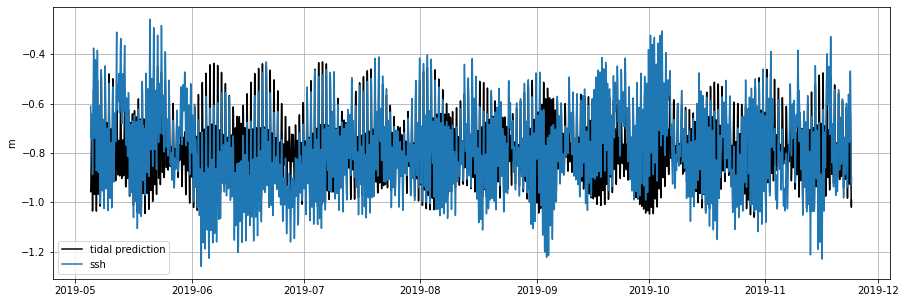

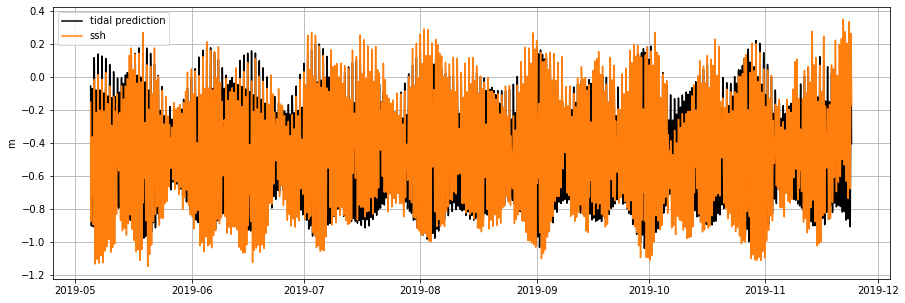

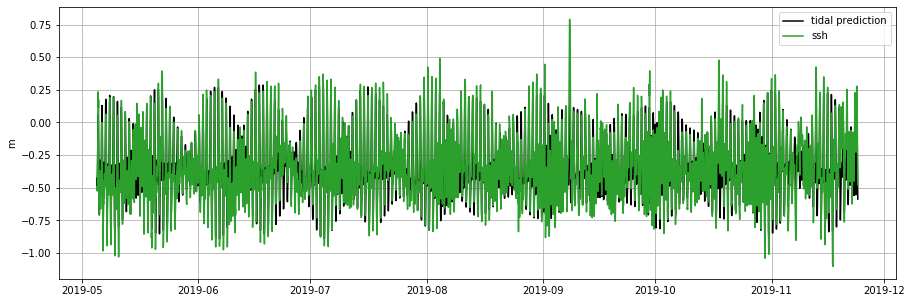

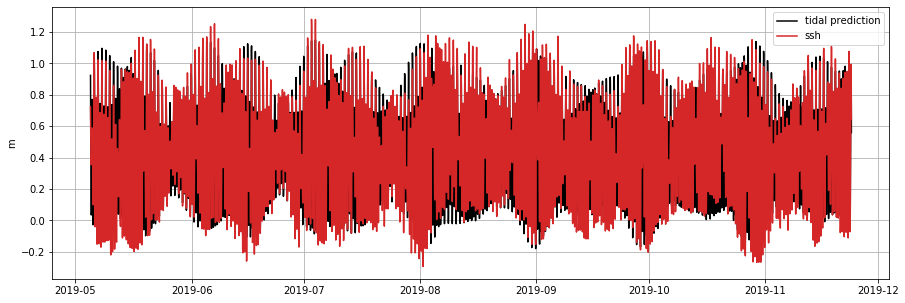

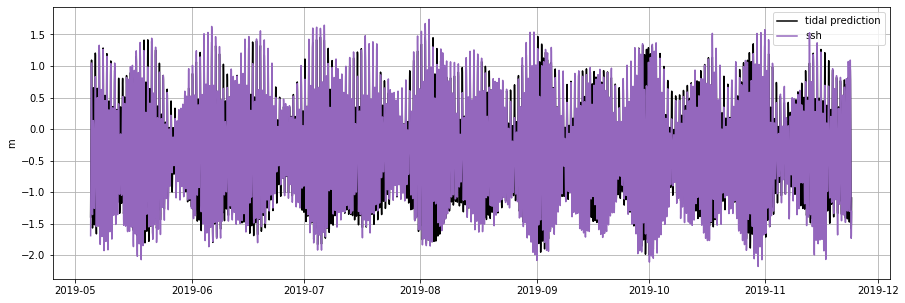

In [15]:
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dt_2D.zos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds)
    ax.plot(prediction.index, prediction.values, color='k', label='tidal prediction')
    ax.plot(speeds.time_counter, speeds.values, color=color, label='ssh',zorder=10)
    ax.grid()
    ax.legend()
    ax.set_ylabel('m')

## Residuals

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

(0, 20000)

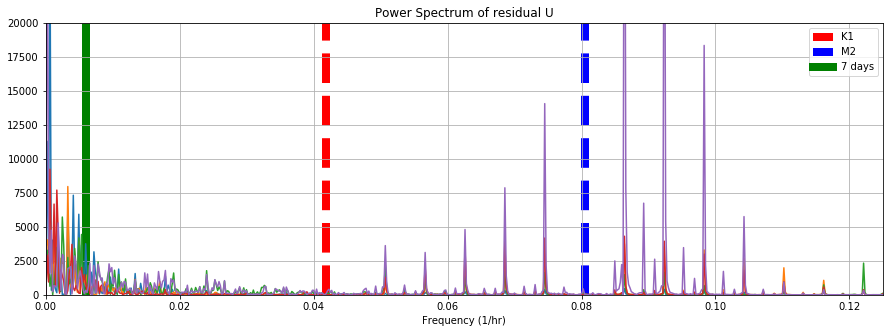

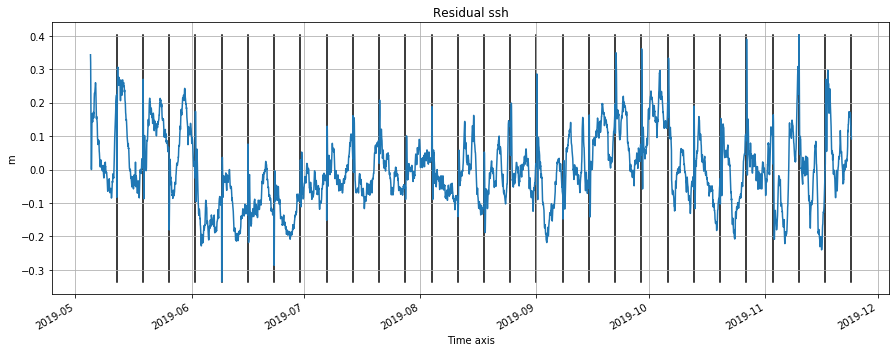

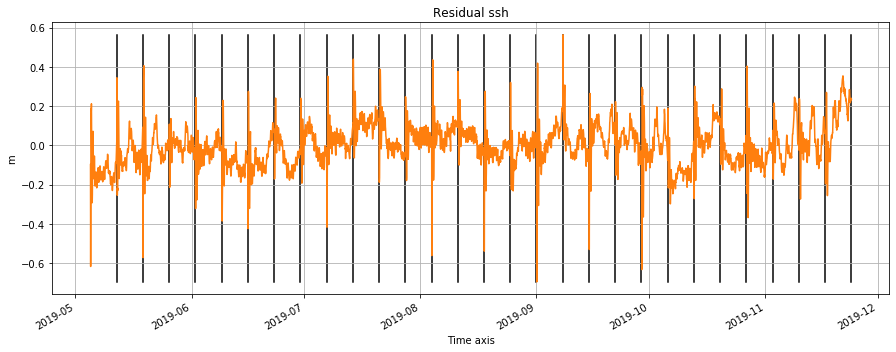

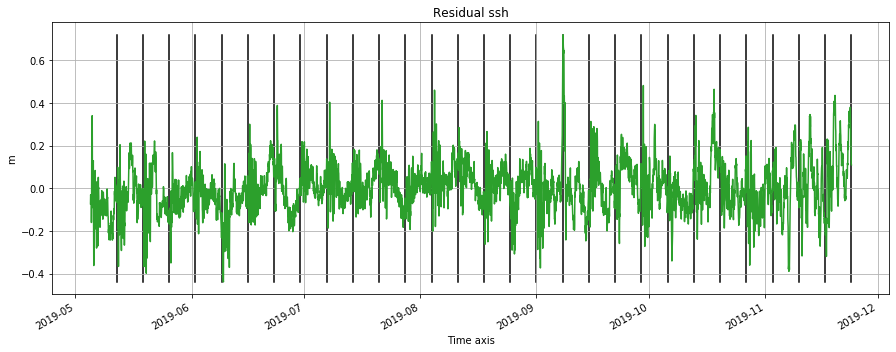

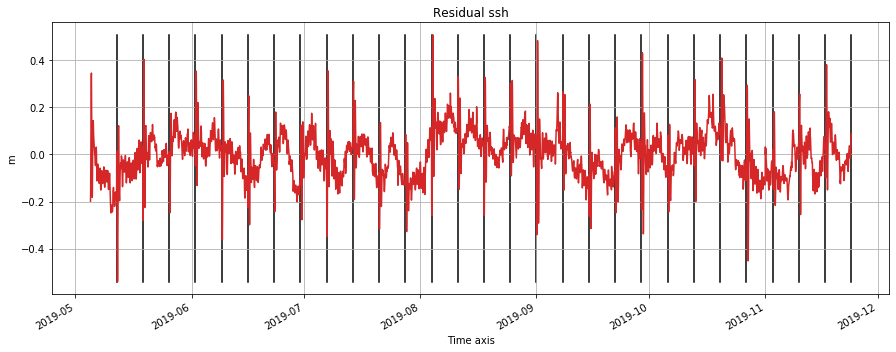

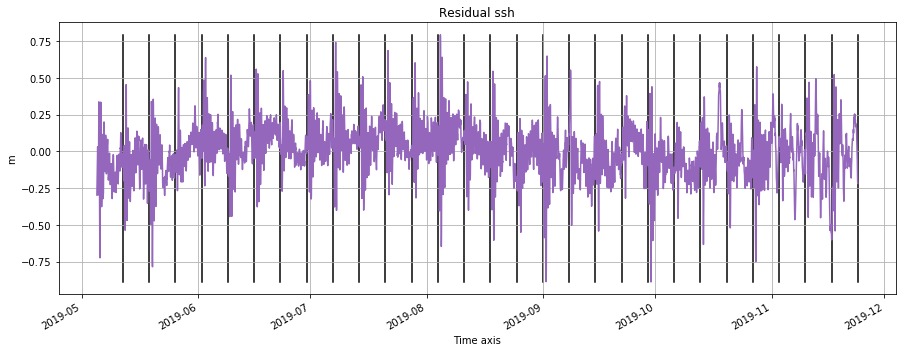

In [16]:
figs, axs=plt.subplots(1,1,figsize=(15,5))
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dt_2D.zos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    residual.plot(ax=ax, color=color)
    ax.set_title('Residual ssh')
    minvar=residual.min()
    maxvar=residual.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-',zorder=0)
    ax.grid()
    ax.set_ylabel('m')
    # power spectrum
    freqs = np.fft.fftfreq(residual.values.size, 1)
    idx = np.argsort(freqs)
    psd = np.abs(np.fft.fft(residual.values))**2
    axs.plot(freqs[idx], psd[idx], c=color, label='__nolegend__')
axs.set_title('Power Spectrum of residual U')
axs.grid()
m=20000
# K1
axs.plot([1/23.93, 1/23.93], [0,m], 'r--', lw=8,label='K1',zorder=0)
# M2
axs.plot([1/12.42, 1/12.42], [0,m], 'b--', lw=8, label='M2',zorder=0)
# 7 days
axs.plot([1/(7*24.), 1/(7*24.)], [0,m], 'g-', lw=8, label='7 days',zorder=0)
axs.legend()
axs.set_xlabel('Frequency (1/hr)')
axs.set_xlim([0,0.125])
axs.set_ylim([0,m])

## Daily average residual

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/core.py:3611: FutureWarning: Series.data is deprecated and will be removed in a future version
  elif hasattr(a, "data") and type(a).__module__.startswith("xarray."):
/home/soontiensn/minicon

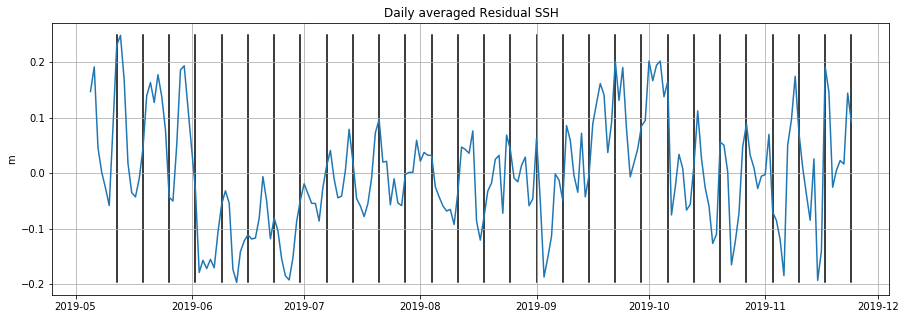

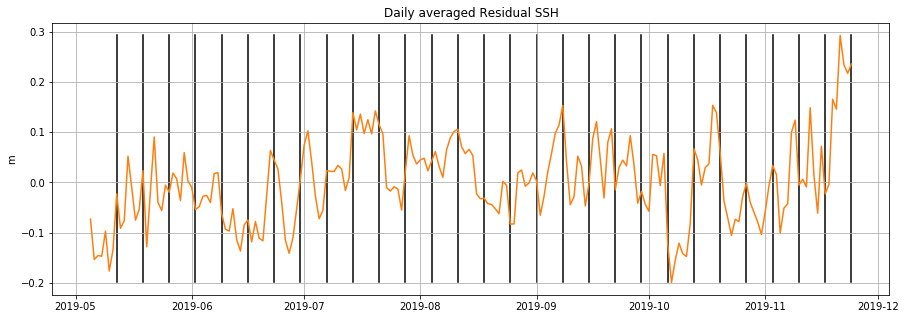

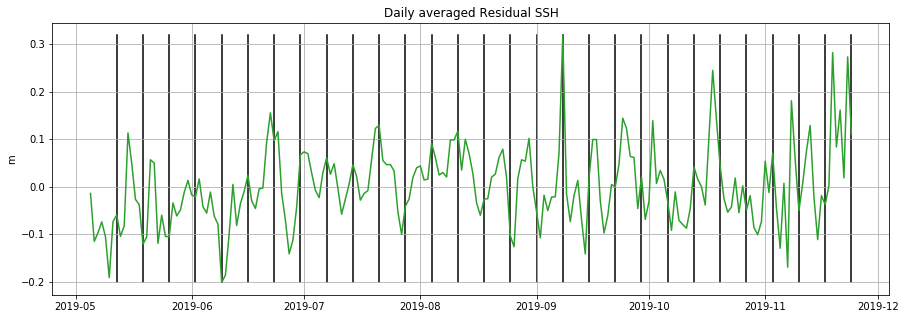

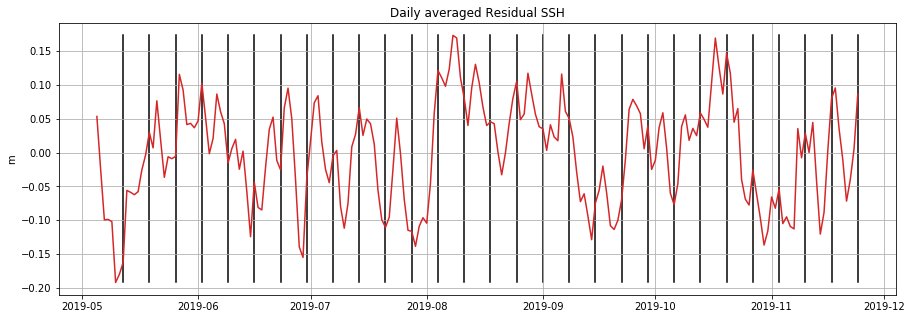

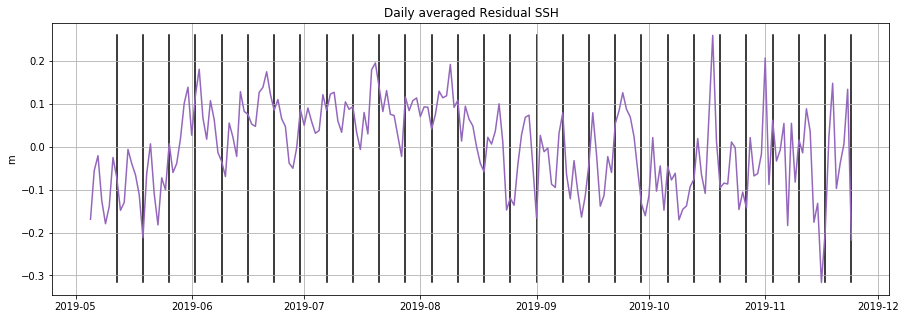

In [17]:
for c, color in zip(coords, colors):
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    speeds = dt_2D.zos.isel(x=c[0],y=c[1])
    tide, prediction = tidal_analysis(speeds, print_const=False)
    
    residual = speeds - prediction
    daily = residual.to_dataframe(name='zos').resample('1D').mean()
    ax.plot(daily.index, daily.zos.values, color=color)
    ax.set_title('Daily averaged Residual SSH')
    minvar=daily.zos.min()
    maxvar=daily.zos.max()
    for d in restart_days:
        ax.plot([d,d], [minvar, maxvar], 'k-', zorder=0)
    ax.grid()
    ax.set_ylabel('m')

# Summary
* There is a clear spike in the residual ssh every 7 days.
* This spike is not prevalent in the residual u and v surface currents.
* As such any impact of the tidal ramping on the daily average currents is likely negligible.

Note: only 5 points we sampled. This analysis could be extended to more points in the domain. Two points are near the boundaries, one is near the domain centre and two are in the GSL. 